# Mathematics of Poker
 Part 1, Chapter 2:  Predicting the Future and Sample Outcomes

-----------------------

### [I. Calculating Winning Sessions from Player Stats](#akaq)
Page 28
### [II. AK v AQ Story](#wins)
Pages 29-30
### [III. Law of Large Numbers Player with Example](#lln)
Page 31


-----------------


### I. Calculating Winning Sessions from Player Stats <a name="wins"></a>

In this section we answer some real life questions which require deploying our recently learned probability concepts 

In [98]:
from scipy.stats import norm # norm.cdf for the cumulative normal distribution function
from numpy import std, sqrt # for probability calculations
import numpy as np # other numpy convenience functions 

def win_session_probability(winrate, standard_deviation, hands_played, greater_than=0):
    """Calculate probability that a poker session will be a winning one given some player statitics
    
    Parameters
    ----------
    
    winrate: float
        the player winrate in units per hand. This is also the expectation. 
        
    standard_deviation: float 
        the standardard deviation over the same interval of hands used to calculate the winrate
        for example, if you have play 10 hands and have winnings of 
        [0, 1, 1, 0, -2, 10, -2, 0, 0, 1] => 9 units
        then your winrate = sum(winnings)/total_hands => 0.9 units per hand 
        and your standard deviation is 3.38 -- calculate this on your own
        
    hands_played: int
        the number of hands for which we will provide an estimate
        
    greater_than: int
        default to 0
        The outcome we are interested in
        if set to x, this function returns the probability that the player earns greater than x units
        
        
    Returns
    -------
    
    probability: float
        the probability the player has a winning session. 
        This is equal to:
            1 - phi(z_score)    
    """
    
    # first we need to get the expectation over the sample 
    # this is just equal to the winrate * sample_size
    
    expected_value_over_sample = winrate * hands_played
    
    
    # next we will calculate the standard deviation over hands_played
    
    sigma_over_hands = sqrt(hands_played) * standard_deviation
    
    
    # now that we have both of these values, we can calculate the z-score
    # the z-score is passed into the CDF to get the probability estimate
    
    z_score = (greater_than - expected_value_over_sample) / sigma_over_hands 
    
    # pass that to the CDF function
    phi_of_z = norm.cdf(z_score)
    
    
    # we take 1 - phi_of_z because that function returns the probability that the outcome will be LESS than 0
    return 1-phi_of_z



# verify against the page in the book
win_session_probability(0.015, 2, 300)

# 0.5517 is correct

0.5516787352796411

Now we can answer some more general questions. 

**What is the probability a player with these statistics will win at least 100 units over 3000 hands?**

In [85]:
# plug it in
win_session_probability(winrate=0.015, standard_deviation=2, hands_played=3000, greater_than=100)

0.30780597184951286

This player should expect to win at least 100 units over 3000 hands about 30% of the time with a winrate of 0.015 units per hand and a standard deviation of 2 over the same interval. 

### II. AK - AQ Story <a name="akaq"></a>

Pages 29-30

---------------

One player claimed that over a sample of around 2000 hands, AK v AQ were running 50-50. Is this player telling the truth? is the site rigged? we don't know, but how likely is this? 

In [86]:
# If we assign a value of 1 when AK wins and 0 when AQ wins, then the expectation (or mean) is 0.735
# we'll get the probability that AQ wins 50% or more of the time


def check_ak_aq():
    """Proceed as we did in the equation above"""
    
    NUM_HANDS = 2000
    

    # AK v AQ is about 73.5% all in preflop. 
    # one of our first tasks is to define the mean over the sample
    
    expectation = 0.735 
    expectation_over_sample = expectation * NUM_HANDS # since this scenario has 2000 hands 
    
    # next we need to calculate the standard deviation over this sample 
    # Variance = prob_win*(1-expectation)^2 + prob_lose(0-expectation)^2 => sigma^2
    
    variance = 0.735 * (1-expectation)**2 + (1 - 0.735) * (0 - expectation )**2
    
    # now we can get sigma
    sigma = sqrt(variance)
    
    # and then multiply it over the number of hands
    sigma_over_hands = sqrt(NUM_HANDS) * sigma
                        
        
    # then we get the z score
    # we use NUM_HANDS*.5 = 1000 here because we are interested in the chance that AQ wins more than 50% or 1000 hands
    
    z_score = (1000 - expectation_over_sample) / sigma_over_hands
    print("Number of Standard Deviations from the mean estimate:", abs(z_score), "\n")
    
    # then we calculate phi(z_score)
    
    print("Probability: ")                    
    return norm.cdf(z_score)
    

In [32]:
# check the results
check_ak_aq()

Number of Standard Deviations from the mean estimate: 23.81311742871408 

Probability: 


1.221311050119768e-125

**EXCERCISE** 

Modify the function above to take arbitrary numeroc inputs for the expectation and sample size. Consider looking up some other preflop all in hand v hand equities and using those? 


Suppose you play AA v KK 5 times. What is the probability that you lose 3 or more times? Win at least once?

### III. Law of Large Numbers Player with Examples <a name="lln"></a>

In [87]:
# We will draw samples from the probability distribution and record the results in a table as they do in the book
# our results will not be exactly the same, but will be similar enough for this purpose


def create_data(num_hands, player_winrate, variance_per_hand):
    """Given a number of hands, player win rate per 100 hands, and variance per hand, 
    identify 
    - the mean `mu_n`, 
    - the standard deviation `sigma`, 
    - and the two end points of the 95.5% probability interval 
        (ie plus or minus 2 standard deviations from the mean)
    
    Parameters
    ----------
    
    num_hands: int
        the number of hands for the sample
        
    player_winrate: float
        the players win rate per 100 hands.
        Note that in the book they give it per 100 hands here, but *per hand* in the previous example
        Since we want to follow the text, here the win rate is per 100 hands. This is the same units as the variance/100. 
        
    variance_per_hand: float
        the variance per hand. The larger the stakes, the larger we expect the variance to be in general. 
        Same units as the player_win_rate * 100. 
    
    
    Returns
    -------
    
    data: tuple
        (mu_n, sigma, lower endpoint, higher endpoint)
    
    """
    
    # how do we draw samples? 
    # we can draw samples from a normal distribution with a given mean and standard deviation with numpy
    # but we'll need to use our given information to derive them
    
    
    # first we'll get mu_n
    
    # first address the win rate param
    dist_mean = player_winrate / 100.0
    
    # mu_n is simply equal to the dist_mean * num_hands
    mu_n = dist_mean * num_hands
    
    
    # now we can get sigma
    # to do this we need to draw samples from the population
    # to do that, we'll need to first take the square of the variance per hand
    
    # the standard deviation
    sd = sqrt(variance_per_hand)
    
    # create an array of samples
    # loc is the mean, scale is the standard deviation
    sample = np.random.normal(loc=75, scale=sd, size=num_hands)
    
    # get the standard deviation *of the sample* to return later
    sigma = sqrt(num_hands)*std(sample, ddof=1)
    
    
    # now we can calculate the lower and upper bounds as well
    
    lower_bound = mu_n - 2 * sigma
    upper_bound = mu_n + 2 * sigma
    
    return (mu_n, round(sigma,2), round(lower_bound,2), round(upper_bound,2))
    
    
# test a sample
create_data(num_hands=100, player_winrate=75, variance_per_hand=6400)

(75.0, 831.97, -1588.94, 1738.94)

Now we can generate some samples and observe the data

In [88]:
# for the pretty printed dataframe with a spreadsheet like view
import pandas as pd
from IPython.display import HTML

# first set the sample sizes we intend to draw
# low end is 100, high end is 100k
SAMPLE_SIZE_LIST = [100, 500, 1000, 5000, 25000, 50000, 100000, 1000000]
TABLE_COLUMN_NAMES = ['Mu_N','Sigma', 'Lower endpoint', 'Higer endpoint']

# create the data for all the sample size
data = [create_data(num_hands=sample_size, player_winrate=75, variance_per_hand=6400) for sample_size in SAMPLE_SIZE_LIST]

df = pd.DataFrame(data=data, columns=TABLE_COLUMN_NAMES, index=SAMPLE_SIZE_LIST)
df.index.name = 'Hands'

# renders
HTML(df.to_html())

,Mu_N,Sigma,Lower endpoint,Higer endpoint
Hands,,,,
100,75.0,908.57,-1742.14,1892.14
500,375.0,1801.10,-3227.20,3977.20
1000,750.0,2475.07,-4200.14,5700.14
5000,3750.0,5677.74,-7605.48,15105.48
25000,18750.0,12711.51,-6673.03,44173.03
50000,37500.0,17829.84,1840.33,73159.67
100000,75000.0,25245.93,24508.14,125491.86
1000000,750000.0,79993.38,590013.24,909986.76


Now, the authors mention that 

```
Comparing the standard deviation of one million hands to the standard deviation for one hundred hands, 
the size of the standard deviationis a hundered times as large in absolute terms, 
but more than a hundred times smaller relative to the number of hands. 
This is the **law of large numbers** at work. 
The larger the sample, the closer on a relative basis the outcomes of the sample will be. 
```

Given the data above, how can we visualize this?  Let's calculate the ratio of the standard deviation to the number of hands and plot this. 

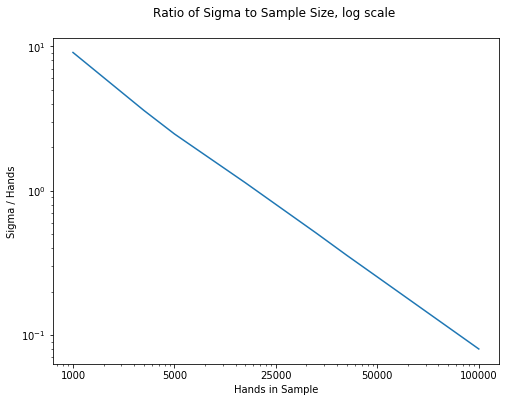

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting

# you can get this data easily from the dataframe 
# the index contains the data for the number of hands 
# this is the data for our Y axis
# the X axis will the number of hands (ie the sample size / SAMPLE_SIZE_LIST)

ratio_data = (df.Sigma/df.index.values).values


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)

# set log scale for axes
ax.set_xscale('log')
ax.set_yscale('log')

# design
ax.set_xticklabels(SAMPLE_SIZE_LIST)
plt.title("Ratio of Sigma to Sample Size, log scale \n") 
plt.ylabel("Sigma / Hands")
plt.xlabel("Hands in Sample")



plt.plot(SAMPLE_SIZE_LIST, ratio_data)

plt.show()


